# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [63]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import SGDClassifier

from sklearn.cross_validation import train_test_split
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.svm import SVC
from wordcloud import WordCloud
from sklearn.calibration import CalibratedClassifierCV

In [90]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


#parti
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [91]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [92]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [93]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [94]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [95]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [96]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [97]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [98]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [99]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [100]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [101]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [102]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [103]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [104]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [105]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [106]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [107]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:11<00:00, 2765.24it/s]


In [108]:
final['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [109]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [110]:
con = sqlite3.connect("final.sqlite")
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

In [111]:
final.sort_values("Time",ascending=True, inplace=True, kind='quicksort')

In [112]:
final['Score'].replace(['negative', 'positive'],[0,1],inplace=True)

In [113]:
final = final.to_csv("final.csv")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

*  create column of cleanedtext and save preprocessed_reviews.
*  sort data with time.
*  convert negative class with 0 and positive class with 1.
*  then we save in sqlite.
*  then convert sqlite file to csv file.

In [6]:
final = pd.read_csv("final.csv") # reading csv file

In [7]:
final = final.iloc[:100000] #taking 100k point

In [8]:
X = final["CleanedText"]
y = final["Score"]

## Function

### 1.SGD with hinge-loss

In [9]:
def SGD(X_train, X_test, y_train, y_test):
    
    start=datetime.now()
    
    #Normalize Data
    X_train = preprocessing.normalize(X_train)
    print ("Train Data Size: ",X_train.shape)
    #Normalize Data
    X_test = preprocessing.normalize(X_test)
    print ("Test Data Size: ",X_test.shape)
    
    print("SGD Classifier")
    model=SGDClassifier()
    penalty=['l1', 'l2']
    param={'alpha': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50, 100,500,1000], 'penalty':penalty}
    gsv =GridSearchCV(estimator=model, param_grid=param,  n_jobs=-1, verbose=1)
    gsv.fit(X_train,y_train)
    
    penalty=model.get_params()['penalty']
    alpha=model.get_params()['alpha']
    print('best alpha=',alpha)
    print('best penalty=',penalty)
    
    model1 = SGDClassifier(penalty= penalty, alpha=alpha)
    
    model1.fit(X_train,y_train)
    y_pred = model1.predict(X_test)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    
    test=CalibratedClassifierCV(model)
    test.fit(X_train,y_train)
    print('ROC curve--')
    y_pred_proba=test.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.plot([0,1],[0,1],linestyle='--')
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.show()
    
        
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    #skplt.plot_confusion_matrix(y_test ,y_pred)
    
    end=datetime.now()
    print('duration = ',(end-start))
    
    return penalty,alpha


### 2.Word cloud 

In [10]:
##code borrowed from  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_cloud(vectorizer, w, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    positive = []
    negative = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        positive.append(fn_2)
        negative.append(fn_1)
    positive = ' '.join(positive)
    
    #wordcloud for postitve word
    
    wordcloud  = WordCloud(max_font_size=40).generate(positive)
    plt.figure()
    plt.title("wordcloud for positive class words")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    print('*****************************************************')
    
    negative = ' '.join(negative)
   
    #wordcloud for negative word
    
    wordcloud  = WordCloud(max_font_size=40).generate(negative)
    plt.figure()
    plt.title("wordcloud for negative class words")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# [4] Featurization

## [4.1] BAG OF WORDS

In [11]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [12]:
#Bow
count = CountVectorizer() 

Bow_train = count.fit_transform(X_train)

Bow_test = count.transform(X_test)


In [13]:
Bow_train = preprocessing.normalize(Bow_train)
print("Train Data Size: ",Bow_train.shape)

#Normalize Data
Bow_test = preprocessing.normalize(Bow_test)
print("Train Data Size: ",Bow_test.shape)

Train Data Size:  (70000, 31561)
Train Data Size:  (30000, 31561)


## [4.3] TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_train = tf_idf_vect.fit_transform(X_train)
tf_idf_test = tf_idf_vect.transform(X_test)

In [15]:
tf_idf_train = preprocessing.normalize(tf_idf_train)
print("Train Data Size: ",tf_idf_train.shape)

#Normalize Data
tf_idf_test = preprocessing.normalize(tf_idf_test)
print("Train Data Size: ",tf_idf_test.shape)

Train Data Size:  (70000, 40525)
Train Data Size:  (30000, 40525)


## [4.4] Word2Vec

In [17]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [18]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=200, workers=4)

In [19]:
w2v_words = list(w2v_model.wv.vocab)

In [20]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

In [21]:
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=200, workers=4)   

In [22]:
w2v_words_test = list(w2v_model_test.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [23]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [01:00<00:00, 1151.26it/s]


70000
200


In [24]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:22<00:00, 1327.80it/s]


30000
200


In [25]:
#Normalize Data
avg_train = preprocessing.normalize(sent_vectors)
print("Train Data Size: ",avg_train.shape)

avg_test = preprocessing.normalize(sent_vectors_test)
print("Train Data Size: ",avg_test.shape)


Train Data Size:  (70000, 200)
Train Data Size:  (30000, 200)


#### [4.4.1.2] TFIDF weighted W2v

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix_train[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [11:36<00:00, 100.53it/s]


70000
200


In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix_test[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:04<00:00, 98.49it/s]


30000
200


In [29]:
#Normalize Data
w2v_tfidf_train = preprocessing.normalize(tfidf_sent_vectors_train)
print("Train Data Size: ",w2v_tfidf_train.shape)

w2v_tfidf_test = preprocessing.normalize(tfidf_sent_vectors_test)
print("Train Data Size: ",w2v_tfidf_test.shape)

Train Data Size:  (70000, 200)
Train Data Size:  (30000, 200)


### Taking 40K point for RBF kernel

In [37]:
final = pd.read_csv("final.csv")

In [38]:
final = final.iloc[:40000] #taking 40k point

In [39]:
X = final["CleanedText"]
y = final["Score"]

## Function

In [40]:
# defining model function that does cross validation , accuracy, test accuracy 
# and confusion matrix
# this function takes 'search', 'X_train', 'X_test', 'y_train', 'y_test' as arguments
def SVM(X_train, X_test, y_train, y_test):
    
    start=datetime.now()
    
    #Normalize Data
    
    print ("Train Data Size: ",X_train.shape)
    #Normalize Data
    X_test = preprocessing.normalize(X_test)
    print ("Test Data Size: ",X_test.shape)
    
    
    #params we need to try on classifier

    print("SVC GridSearch")
    model =SVC()
    gamma=[0.0001, 0.001,  0.01, 0.05, 0.1, 0.5, 1, 5, 10]
    param={'C': [0.001,  0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'gamma':gamma}
    gsv = CV=GridSearchCV(estimator=model, param_grid=param, verbose=1, n_jobs=-1)
    gsv.fit(X_train,y_train)
    

    c=gsv.best_estimator_.get_params()['C']
    gamma=gsv.best_estimator_.get_params()['gamma']
    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
      
    test = SVC(C=c,gamma=gamma,probability=True)
    test.fit(X_train,y_train)
    y_pred = test.predict(X_test)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    
    print('ROC curve--')
    y_pred_proba=test.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.plot([0,1],[0,1],linestyle='--')
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.show()
    
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    #skplt.plot_confusion_matrix(y_test ,y_pred)
    
    end=datetime.now()
    print('duration = ',(end-start))
    

### [4.1] BAG OF WORDS

In [41]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
#Bow
count = CountVectorizer(min_df = 10, max_features = 500) 

Bow_train = count.fit_transform(X_train)

Bow_test = count.transform(X_test)


In [43]:
Bow_train = preprocessing.normalize(Bow_train)
print("Train Data Size: ",Bow_train.shape)

#Normalize Data
Bow_test = preprocessing.normalize(Bow_test)
print("Train Data Size: ",Bow_test.shape)

Train Data Size:  (28000, 500)
Train Data Size:  (12000, 500)


## [4.2] TF-IDF

In [44]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features = 500)
tf_idf_train = tf_idf_vect.fit_transform(X_train)
tf_idf_test = tf_idf_vect.transform(X_test)

In [45]:
tf_idf_train = preprocessing.normalize(tf_idf_train)
print("Train Data Size: ",tf_idf_train.shape)

#Normalize Data
tf_idf_test = preprocessing.normalize(tf_idf_test)
print("Train Data Size: ",tf_idf_test.shape)

Train Data Size:  (28000, 500)
Train Data Size:  (12000, 500)


## [4.4] Word2Vec

In [46]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [47]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=200, workers=4)

In [48]:
w2v_words = list(w2v_model.wv.vocab)

In [49]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    list_of_sent_test.append(sent.split())

In [50]:
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=200, workers=4)   

In [51]:
w2v_words_test = list(w2v_model_test.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [52]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 28000/28000 [00:21<00:00, 1291.72it/s]


28000
200


In [53]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:08<00:00, 1453.98it/s]


12000
200


In [54]:
#Normalize Data
avg_train = preprocessing.normalize(sent_vectors)
print("Train Data Size: ",avg_train.shape)

avg_test = preprocessing.normalize(sent_vectors_test)
print("Train Data Size: ",avg_test.shape)


Train Data Size:  (28000, 200)
Train Data Size:  (12000, 200)


#### [4.4.1.2] TFIDF weighted W2v

In [55]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
tf_idf_matrix_test = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [56]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix_train[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [03:32<00:00, 131.99it/s]


28000
200


In [57]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix_test[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:22<00:00, 145.51it/s]


12000
200


In [58]:
#Normalize Data
w2v_tfidf_train = preprocessing.normalize(tfidf_sent_vectors_train)
print("Train Data Size: ",w2v_tfidf_train.shape)

w2v_tfidf_test = preprocessing.normalize(tfidf_sent_vectors_test)
print("Train Data Size: ",w2v_tfidf_test.shape)

Train Data Size:  (28000, 200)
Train Data Size:  (12000, 200)


# [5] Assignment 7: SVM

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

Train Data Size:  (70000, 31561)
Test Data Size:  (30000, 31561)
SGD Classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.9s finished


best alpha= 0.0001
best penalty= l2
Accuracy on test set: 91.333%
Precision on test set: 0.914
Recall on test set: 0.995
F1-Score on test set: 0.953
ROC curve--


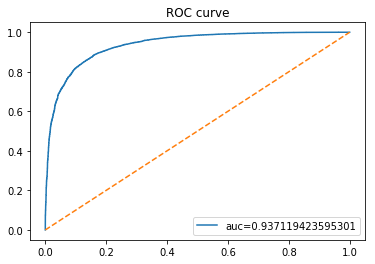

duration =  0:00:14.530640


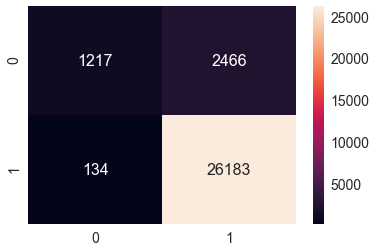

In [30]:
penalty,alpha = SGD(X_train=Bow_train,X_test=Bow_test,y_train=y_train,y_test=y_test)

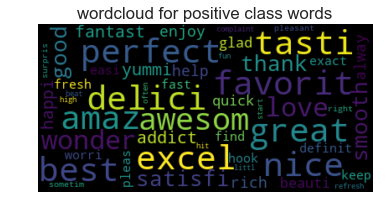

*****************************************************


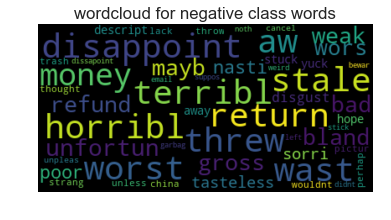

In [31]:
clf = SGDClassifier(penalty= penalty, alpha=alpha)
clf.fit(Bow_train,y_train)
show_cloud(count, clf.coef_)

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Train Data Size:  (70000, 40525)
Test Data Size:  (30000, 40525)
SGD Classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished


best alpha= 0.0001
best penalty= l2
Accuracy on test set: 91.163%
Precision on test set: 0.910
Recall on test set: 0.998
F1-Score on test set: 0.952
ROC curve--


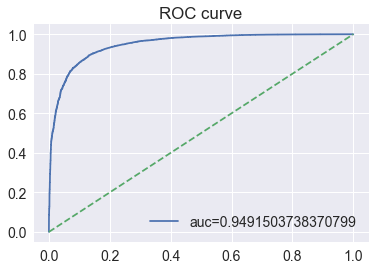

duration =  0:00:16.738014


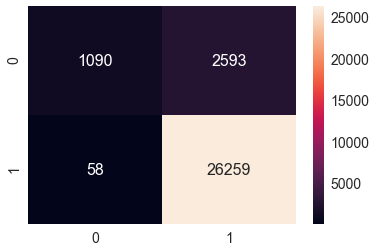

In [32]:
penalty,alpha = SGD(X_train=tf_idf_train,X_test=tf_idf_test,y_train=y_train,y_test=y_test)

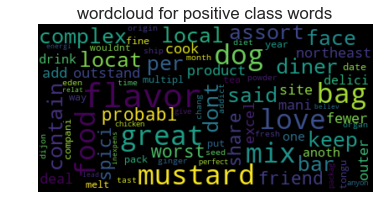

*****************************************************


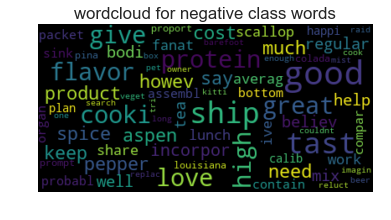

In [33]:
clf = SGDClassifier(penalty= penalty, alpha=alpha)
clf.fit(Bow_train,y_train)
show_cloud(tf_idf_vect, clf.coef_)

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Train Data Size:  (70000, 200)
Test Data Size:  (30000, 200)
SGD Classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.9s finished


best alpha= 0.0001
best penalty= l2
Accuracy on test set: 88.963%
Precision on test set: 0.894
Recall on test set: 0.992
F1-Score on test set: 0.940
ROC curve--


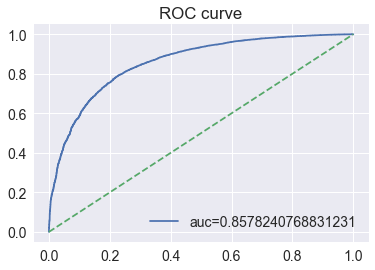

duration =  0:00:27.322994


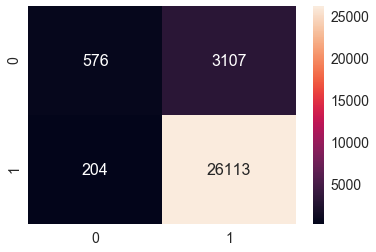

In [34]:
penalty,alpha = SGD(X_train=avg_train,X_test=avg_test,y_train=y_train,y_test=y_test)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Train Data Size:  (70000, 200)
Test Data Size:  (30000, 200)
SGD Classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.9s finished


best alpha= 0.0001
best penalty= l2
Accuracy on test set: 88.860%
Precision on test set: 0.894
Recall on test set: 0.990
F1-Score on test set: 0.940
ROC curve--


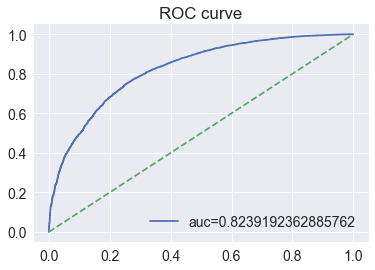

duration =  0:00:26.944971


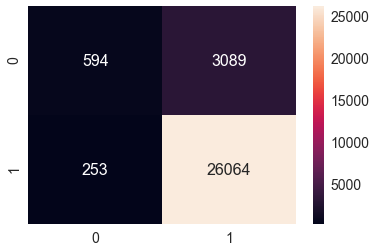

In [35]:
penalty,alpha = SGD(X_train=w2v_tfidf_train,X_test=w2v_tfidf_test,y_train=y_train,y_test=y_test)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

Train Data Size:  (28000, 500)
Test Data Size:  (12000, 500)
SVC GridSearch
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 91.8min finished


Best HyperParameter:  {'C': 5, 'gamma': 0.5}
Best Accuracy: 91.37%
Accuracy on test set: 92.092%
Precision on test set: 0.935
Recall on test set: 0.979
F1-Score on test set: 0.957
ROC curve--


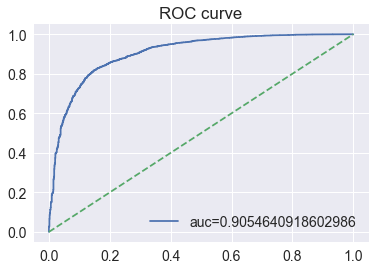

duration =  1:50:25.266501


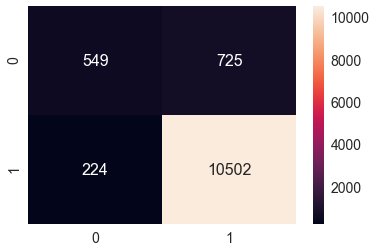

In [59]:
SVM(X_train=Bow_train,X_test=Bow_test,y_train=y_train,y_test=y_test)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

Train Data Size:  (28000, 500)
Test Data Size:  (12000, 500)
SVC GridSearch
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 94.2min finished


Best HyperParameter:  {'C': 5, 'gamma': 0.5}
Best Accuracy: 91.48%
Accuracy on test set: 92.325%
Precision on test set: 0.936
Recall on test set: 0.981
F1-Score on test set: 0.958
ROC curve--


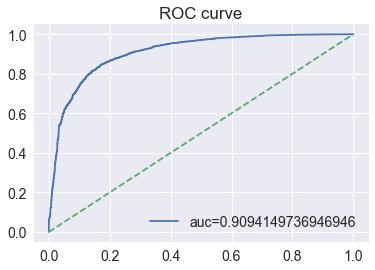

duration =  1:53:53.598457


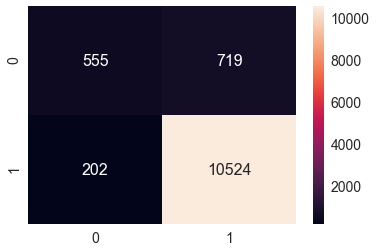

In [60]:
SVM(X_train=tf_idf_train,X_test=tf_idf_test,y_train=y_train,y_test=y_test)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

Train Data Size:  (28000, 200)
Test Data Size:  (12000, 200)
SVC GridSearch
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 121.8min finished


Best HyperParameter:  {'C': 10, 'gamma': 1}
Best Accuracy: 91.20%
Accuracy on test set: 83.892%
Precision on test set: 0.914
Recall on test set: 0.905
F1-Score on test set: 0.909
ROC curve--


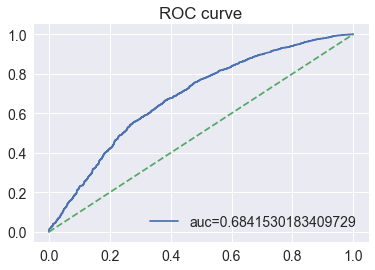

duration =  2:13:45.760831


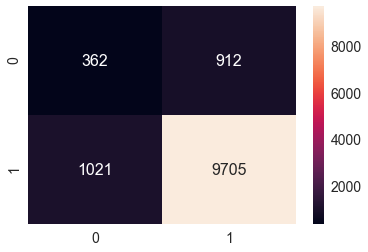

In [61]:
SVM(X_train=avg_train,X_test=avg_test,y_train=y_train,y_test=y_test)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

Train Data Size:  (28000, 200)
Test Data Size:  (12000, 200)
SVC GridSearch
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 97.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 124.4min finished


Best HyperParameter:  {'C': 10, 'gamma': 1}
Best Accuracy: 90.51%
Accuracy on test set: 76.592%
Precision on test set: 0.903
Recall on test set: 0.827
F1-Score on test set: 0.863
ROC curve--


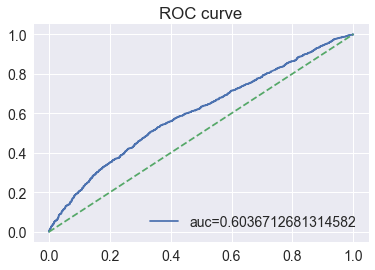

duration =  2:17:33.815122


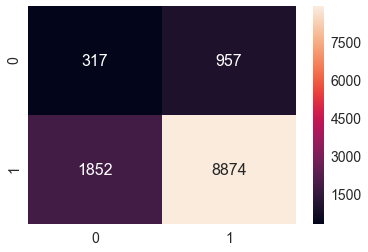

In [62]:
SVM(X_train=w2v_tfidf_train,X_test=w2v_tfidf_test,y_train=y_train,y_test=y_test)

# [6] Conclusions

## [5.1] Linear SVM Performance Table 100K points

|sno	|featurization|best alpha	|best penalty|Accuracy|Precision|Recall |F1-Score|
|-------|-------------|-------------|------------|--------|---------|-------|--------|
|1|Bow|0.0001|l2| 91.333%|0.914| 0.995|0.953|
|2|Tfidf|0.0001|l2|91.163%|0.910|0.998|0.952|
|3|Avg w2v|0.0001|l2|88.963%|0.894|0.992|0.940|
|4|Tfidf w2v|0.0001|l2|88.860%|0.894|0.990|0.940|

## [5.2] RBF SVM Performance Table 40K points

|sno|featurization|best C|best gamma|Accuracy|Precision|Recall|F1-Score|
|---|-------------|------|----------|--------|---------|------|--------|
|1|BOW|5|0.5| 92.092%|0.935|0.979|0.957|
|2|Tfidf|5|0.5|92.325%|0.936|0.981|0.958|
|3|avg w2v|10|1|83.892%|0.914|0.905| 0.909|
|4|tfidf w2v|10|1|76.592%|0.903|0.942|0.863|

* SVC works well in case of Bow and Tfidf.
* In both cases Bow and tfidf work well.
* SVM with RBF kernal take more time than SGD with Hinge-loss.